In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml

#### Loading MNIST data set from openml

In [2]:
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [3]:
X, y = mnist['data'], mnist['target']

y = y.astype(np.uint8)
X = X.astype(np.uint8)

In [4]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


#### Take a deep look of the data set

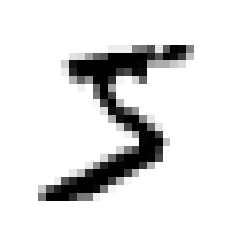

5

In [5]:
random_digit = X[0]
random_digit_image = random_digit.reshape(28, 28)
plt.imshow(random_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()
y[0]

#### Train Test data load

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train.astype(np.int8)

array([5, 0, 4, ..., 5, 6, 8], dtype=int8)

In [7]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training A Binary Classifier for recognizing 5

In [8]:
X_train_5 = (X_train == 5)
X_test_5 = (X_test == 5)
y_train_5 = (y_train == 5) # True if y_train value is 5, else will return flase
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train_5, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict(X_test_5)

array([False, False, False, ..., False, False, False])

In [11]:
sgd_clf.score(X_test_5, y_test_5)

0.9109

### Implementing Cross-Validation

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=None)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_fold = X_train[train_index]
    y_train_fold = y_train[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]
    
    clone_clf.fit(X_train_fold, y_train_fold)
    y_predict = clone_clf.predict(X_test_fold)
    n_correct = sum(y_predict == y_test_fold)
    print(n_correct / len(y_predict))

0.88905
0.86125
0.8329


### Cross-Validation using Sklearn

In [34]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96115, 0.9511 , 0.9631 ])

In [36]:
from sklearn.model_selection import cross_val_predict

y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

y_train_predict

array([False, False,  True, ..., False, False, False])

### Confusion-Matrix

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_predict, y_train_5)

array([[53830,  1744],
       [  749,  3677]])

### Calculating Precision-Score and Recall Score

In [23]:
from sklearn.metrics import precision_score, recall_score
print(recall_score(y_train_predict, y_train_5))
print(precision_score(y_train_predict, y_train_5))

0.8307727067329417
0.6782881387197934


In [25]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_predict)

0.746826444602417

In [27]:
y_scores = sgd_clf.decision_function([random_digit])
print(y_scores)

[-197.46879927]


In [29]:
threshold = 0
y_random_digit_pred = (y_scores > threshold)
y_random_digit_pred

array([False])

In [32]:
threshold = 200000
y_random_digit_pred = (y_scores > threshold)
y_random_digit_pred

array([False])

In [56]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
y_scores

array([-21478.36638762,  -9594.45465967,   1978.25328234, ...,
        -7783.90331089,  -9048.3222706 , -14761.0646536 ])

In [77]:
def precision_recall_threshold_curve(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'r--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')

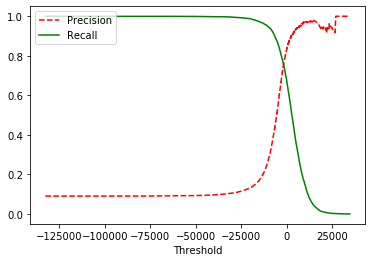

In [78]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
precision_recall_threshold_curve(precisions, recalls, thresholds)
plt.show()

### AUC - ROC Curve

AUC - ROC curve is a performance measurement for classicication problem. a varuous thresholds setting.s ROC is probability curve and AUC represetns degree of measure of separability. It tells how much model is capable of distinghuishing between classes. Higher the AUC, btter the model is at predictiong 0s as 0s and 1s as 1s. The ROC curve is plotted with TPR against the DPR where TPR is on y-axis and FPR is on the x-axis.
<img src="TPR_vs_FPR.png"
     alt="TPR_VS_FPR"
     style="float: left; margin-right: 10px;" />

In [79]:
def roc_curve_plot(tpr, fpr, label=None):
    plt.plot(fpr, tpr, linewidth = 2, label=label)
    plt.plot([0,1],[0,1],[0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

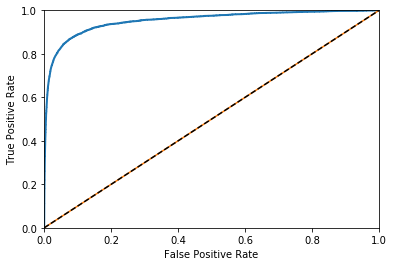

In [80]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
roc_curve_plot(tpr, fpr)

In [83]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.953104658749608

### Random Forest Calssifier

In [74]:
from sklearn.ensemble import RandomForestClassifier

random_clf = RandomForestClassifier(random_state=42)
y_random_forest = cross_val_predict(random_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_random_forest

array([[1.  , 0.  ],
       [1.  , 0.  ],
       [0.23, 0.77],
       ...,
       [0.96, 0.04],
       [0.77, 0.23],
       [1.  , 0.  ]])

In [82]:
print(y_random_forest.shape)
y_forest_score = y_random_forest[:, 1]
y_forest_score.shape

(60000, 2)


(60000,)

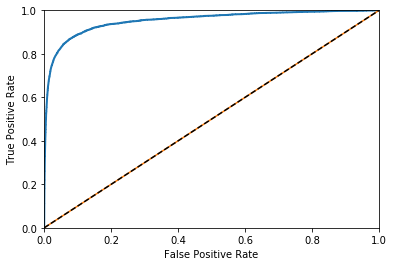

In [84]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores)

roc_curve_plot(tpr_forest, fpr_forest)

In [88]:
roc_auc_score(y_train_5, y_forest_score)

0.9983124147634017

## Multiclass Classifier

In [89]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=4)

In [90]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [91]:
sgd_clf.predict(X_test)

array([0, 6, 5, ..., 7, 4, 8], dtype=uint8)

In [92]:
sgd_clf.score(X_test, y_test)

0.8875

In [96]:
cross_val_score(sgd_clf, X_train, y_train, cv=3)

array([0.87737719, 0.85969893, 0.87281689])

In [ ]:
cross_val_predict(X_train, y_t)